# Analizy przestrzenne rynku mieszkaniowego (Polska)
Źródło danych: pliki CSV z folderu Dane oraz opis z Kaggle (Apartment Prices in Poland).
W notatniku poniżej wykonuję analizy 1, 2, 4, 5 i 6 zgodnie z wymaganiami.

**Uwaga:** Uruchamiaj komórki po kolei (od góry), bo kolejne analizy korzystają z wcześniejszych obliczeń.

## Informacje z Kaggle (skrót)
Dane obejmują oferty sprzedaży i najmu mieszkań z 15 największych miast w Polsce.
Pliki: `apartments_pl_YYYY_MM.csv` (sprzedaż) i `apartments_rent_pl_YYYY_MM.csv` (najem).
Przykładowe pola: `city`, `price`, `squareMeters`, `rooms`, `buildYear`, `latitude`, `longitude`, `centreDistance` (km), cechy budynku i POI.

In [1]:
# Instalacja wymaganych pakietów (uruchom raz w razie potrzeby)
%pip -q install pandas geopandas shapely pyproj contextily folium seaborn matplotlib rtree

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, box
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import folium
from folium.plugins import MarkerCluster

plt.rcParams["figure.figsize"] = (9, 7)
sns.set_style("whitegrid")

In [3]:
data_dir = Path("data")
sales_files = sorted(data_dir.glob("apartments_pl_*.csv"))
rent_files = sorted(data_dir.glob("apartments_rent_pl_*.csv"))

def load_files(files, kind):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df["source_file"] = f.name
        df["kind"] = kind
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

sales = load_files(sales_files, "sale")
rent = load_files(rent_files, "rent")
df = pd.concat([sales, rent], ignore_index=True)

# Zachowujemy tylko potrzebne kolumny (jeśli istnieją)
wanted_cols = ["city", "price", "squareMeters", "rooms", "buildYear", "latitude", "longitude", "centreDistance", "kind", "source_file", "type", "condition"]
cols = [c for c in wanted_cols if c in df.columns]
df = df[cols].copy()

# Podstawowe czyszczenie
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["squareMeters"] = pd.to_numeric(df["squareMeters"], errors="coerce")
df["rooms"] = pd.to_numeric(df["rooms"], errors="coerce")
df["buildYear"] = pd.to_numeric(df["buildYear"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")

df = df.dropna(subset=["price", "latitude", "longitude"])
df = df[df["price"] > 0]

df.head()

city   price  squareMeters  rooms  buildYear   latitude  longitude  \
0  szczecin  415000         63.00    3.0     1980.0  53.378933  14.625296   
1  szczecin  395995         36.00    2.0        NaN  53.442692  14.559690   
2  szczecin  565000         73.02    3.0        NaN  53.452222  14.553333   
3  szczecin  640000         87.60    3.0        NaN  53.435100  14.532900   
4  szczecin  759000         66.00    3.0        NaN  53.410278  14.503611   

   centreDistance  kind                source_file          type condition  
0            6.53  sale  apartments_pl_2023_08.csv  blockOfFlats       NaN  
1            2.15  sale  apartments_pl_2023_08.csv  blockOfFlats       NaN  
2            3.24  sale  apartments_pl_2023_08.csv      tenement       NaN  
3            2.27  sale  apartments_pl_2023_08.csv      tenement       NaN  
4            4.07  sale  apartments_pl_2023_08.csv  blockOfFlats       NaN

In [4]:
# Lista miast w danych
sorted(df["city"].dropna().unique())[:20]

['bialystok',
 'bydgoszcz',
 'czestochowa',
 'gdansk',
 'gdynia',
 'katowice',
 'krakow',
 'lodz',
 'lublin',
 'poznan',
 'radom',
 'rzeszow',
 'szczecin',
 'warszawa',
 'wroclaw']

In [5]:
# Wybierz miasto do analiz
CITY = "Warszawa"  # zmień w razie potrzeby
KIND = "sale"  # "sale" lub "rent"

city_df = df[df["city"].str.casefold() == CITY.casefold()].copy()
city_df = city_df[city_df["kind"] == KIND]
city_df = city_df.dropna(subset=["latitude", "longitude", "price"])

gdf_city = gpd.GeoDataFrame(
    city_df,
    geometry=gpd.points_from_xy(city_df["longitude"], city_df["latitude"]),
    crs="EPSG:4326",
)

len(gdf_city)

59246

In [6]:
def make_grid(gdf, cell_size_m=1000, crs="EPSG:2180"):
    gdf_m = gdf.to_crs(crs)
    minx, miny, maxx, maxy = gdf_m.total_bounds
    xs = np.arange(minx, maxx + cell_size_m, cell_size_m)
    ys = np.arange(miny, maxy + cell_size_m, cell_size_m)
    polys = []
    for x in xs[:-1]:
        for y in ys[:-1]:
            polys.append(box(x, y, x + cell_size_m, y + cell_size_m))
    grid = gpd.GeoDataFrame({"geometry": polys}, crs=crs)
    grid["grid_id"] = np.arange(len(grid))
    return grid

def aggregate_to_grid(gdf, grid, value_col, agg="mean"):
    gdf_m = gdf.to_crs(grid.crs)
    joined = gpd.sjoin(gdf_m, grid, how="inner", predicate="within")
    series = joined.groupby("grid_id")[value_col].agg(agg)
    series = series.rename(f"{value_col}_{agg}")
    out = grid.set_index("grid_id").join(series).reset_index()
    return out

## 1. Mapa średnich cen w siatce (Grid Analysis)

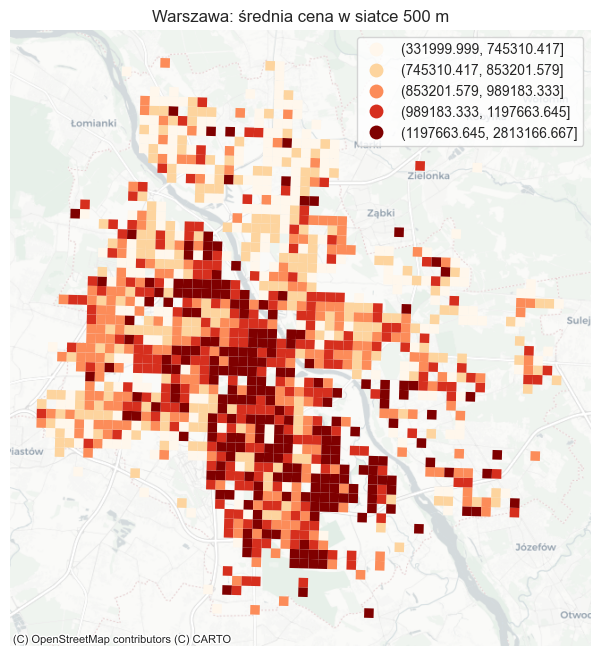

In [15]:
grid_size_m = 500
grid = make_grid(gdf_city, cell_size_m=grid_size_m)
grid_mean = aggregate_to_grid(gdf_city, grid, "price", agg="mean")
grid_mean = grid_mean.dropna(subset=["price_mean"])

# Klasyfikacja kwantylowa dla czytelnych kolorów
grid_mean["price_q"] = pd.qcut(grid_mean["price_mean"], q=5, duplicates="drop")

ax = grid_mean.to_crs(3857).plot(
    column="price_q",
    cmap="OrRd",
    categorical=True,
    legend=True,
    edgecolor="none",
    figsize=(8, 8),
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"{CITY}: średnia cena w siatce {grid_size_m} m")
ax.set_axis_off()
plt.show()

## 2. Analiza „Centrum vs Peryferia” (Distance Decay)

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

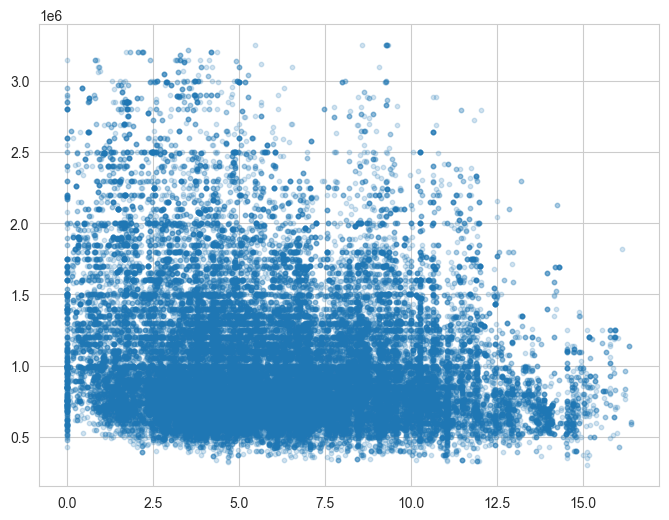

In [8]:
# Przybliżone współrzędne centrum dla wybranych miast
city_centers = {
    "Warszawa": (52.2297, 21.0122),
    "Kraków": (50.0614, 19.9366),
    "Wrocław": (51.1079, 17.0385),
    "Poznań": (52.4064, 16.9252),
    "Gdańsk": (54.3520, 18.6466),
    "Łódź": (51.7592, 19.4550),
    "Szczecin": (53.4285, 14.5528),
    "Bydgoszcz": (53.1235, 18.0084),
    "Lublin": (51.2465, 22.5684),
    "Katowice": (50.2649, 19.0238),
    "Białystok": (53.1325, 23.1688),
    "Częstochowa": (50.8118, 19.1203),
}

if CITY in city_centers:
    lat_c, lon_c = city_centers[CITY]
else:
    # fallback: centroid z danych
    lat_c = gdf_city["latitude"].mean()
    lon_c = gdf_city["longitude"].mean()

center_point = gpd.GeoSeries([Point(lon_c, lat_c)], crs="EPSG:4326").to_crs("EPSG:2180").iloc[0]
gdf_city_m = gdf_city.to_crs("EPSG:2180")
gdf_city_m["dist_km"] = gdf_city_m.distance(center_point) / 1000.0

plt.figure(figsize=(8, 6))
sns.regplot(
    data=gdf_city_m, x="dist_km", y="price",
    scatter_kws={"alpha": 0.2, "s": 10},
    line_kws={"color": "crimson"},
    lowess=True,
)
plt.title(f"{CITY}: Cena vs odległość od centrum")
plt.xlabel("Odległość od centrum [km]")
plt.ylabel("Cena [PLN]")
plt.show()

## 4. Porównanie rynku wtórnego i pierwotnego (Small Multiples)

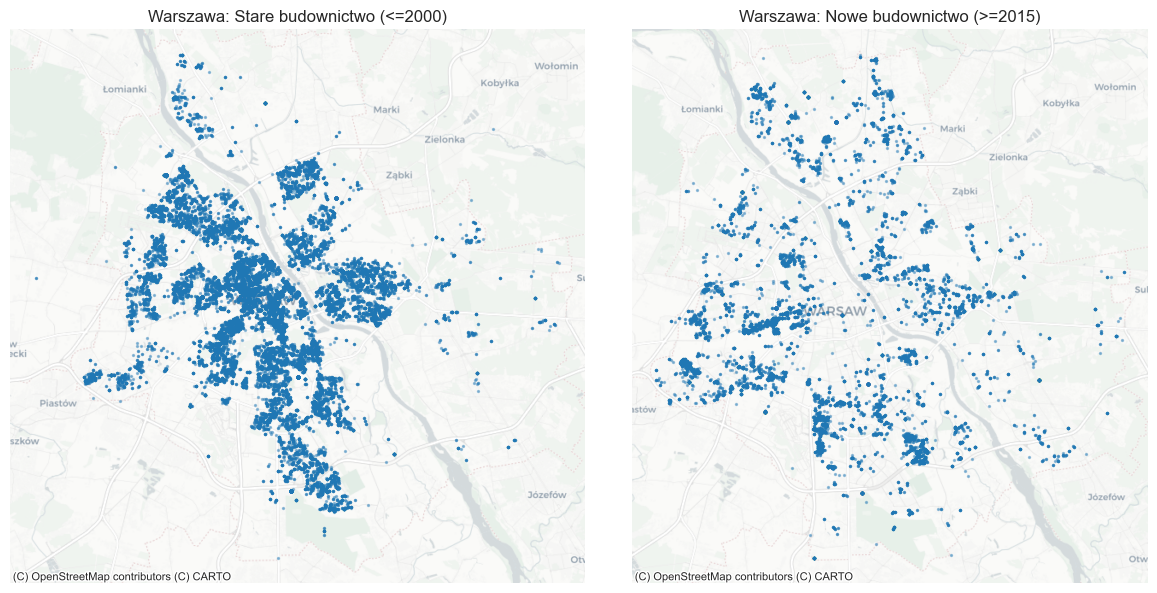

In [16]:
old_buildings = gdf_city[gdf_city["buildYear"].notna() & (gdf_city["buildYear"] <= 2000)]
new_buildings = gdf_city[gdf_city["buildYear"].notna() & (gdf_city["buildYear"] >= 2015)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, subset, title in [
    (axes[0], old_buildings, "Stare budownictwo (<=2000)"),
    (axes[1], new_buildings, "Nowe budownictwo (>=2015)"),
]:
    subset.to_crs(3857).plot(ax=ax, markersize=2, alpha=0.4, color="#1f77b4")
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(f"{CITY}: {title}")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## 5. Interaktywna mapa dla klienta (Wyszukiwarka)

In [17]:
# Próbkowanie, aby mapa była wydajna
sample_n = min(5000, len(gdf_city))
gdf_sample = gdf_city.sample(sample_n, random_state=42) if sample_n > 0 else gdf_city

# Centrum mapy
map_center = [lat_c, lon_c]
m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

def add_layer(data, name, color):
    cluster = MarkerCluster(name=name)
    for _, row in data.iterrows():
        popup = folium.Popup(
            f"Cena: {row['price']:.0f} PLN<br>"
            f"Metraż: {row.get('squareMeters', np.nan):.1f} m²<br>"
            f"Pokoje: {row.get('rooms', np.nan)}<br>"
            f"Rok budowy: {row.get('buildYear', np.nan)}",
            max_width=300,
        )
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=popup,
        ).add_to(cluster)
    cluster.add_to(m)

# Warstwy: kawalerki (1 pokój) i duże mieszkania (>=4 pokoje)
add_layer(gdf_sample[gdf_sample["rooms"] == 1], "Kawalerki", "#2ca02c")
add_layer(gdf_sample[gdf_sample["rooms"] >= 4], "Duże mieszkania (>=4 pokoje)", "#d62728")
add_layer(gdf_sample[(gdf_sample["rooms"] > 1) & (gdf_sample["rooms"] < 4)], "Pozostałe", "#1f77b4")

folium.LayerControl().add_to(m)
m

## 6. Gęstość ofert (Gdzie jest największy wybór?)

In [ ]:
grid_count = aggregate_to_grid(gdf_city, grid, "price", agg="count")
grid_count = grid_count.dropna(subset=["price_count"])

grid_count["count_q"] = pd.qcut(grid_count["price_count"], q=5, duplicates="drop")

ax = grid_count.to_crs(3857).plot(
    column="count_q",
    cmap="Blues",
    categorical=True,
    legend=True,
    edgecolor="none",
    figsize=(8, 8),
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"{CITY}: gęstość ofert (liczba ogłoszeń w siatce {grid_size_m} m)")
ax.set_axis_off()
plt.show()